In [90]:
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [91]:
# Load in files
forwards = pd.read_csv('/Users/blairjdaniel/lighthouse/lighthouse/NHL/NHL_points_projection/files/master_copies/forward_final.csv')
defense = pd.read_csv('/Users/blairjdaniel/lighthouse/lighthouse/NHL/NHL_points_projection/files/master_copies/defense_final.csv')

In [92]:
# Concat df to keep only one set of cols
players = pd.concat([forwards, defense], ignore_index=True)
#players = players.drop(columns=(['Unnamed: 0.1', 'Unnamed: 0']))
players.head()

,name,team,d_zone_shift_starts,giveaways,goals,high_danger_goals,high_danger_shots,hits,low_danger_goals,low_danger_shots,...,games_played,icetime,on_ice_corsi_percentage,on_ice_fenwick_percentage,penalties_drawn,position,shots_blocked_by_player,assists,position_encoded,salary
0,A.J. Greer,FLA,0.125000,0.051471,0.079412,0.014706,0.102941,1.360294,0.013235,0.295588,...,68,9.549755,0.000750,0.000735,0.036765,F,0.161765,0.145588,1,950000.0
1,Aatu Raty,VAN,0.119048,0.019048,0.085714,0.000000,0.000000,1.261905,0.014286,0.200000,...,21,9.505556,0.002333,0.002190,0.009524,F,0.095238,0.085714,1,950000.0
2,Adam Edstrom,NYR,0.233333,0.037255,0.088235,0.009804,0.107843,0.921569,0.005882,0.141176,...,51,9.273529,0.000882,0.000882,0.019608,F,0.333333,0.070588,1,950000.0
3,Adam Fantilli,CBJ,0.117910,0.113433,0.282090,0.044776,0.074627,0.694030,0.013433,0.774627,...,67,17.784080,0.000761,0.000746,0.025373,F,0.365672,0.282090,1,950000.0
4,Adam Gaudette,OTT,0.084615,0.056923,0.221538,0.046154,0.107692,0.438462,0.013846,0.383077,...,65,10.537179,0.000877,0.000877,0.003077,F,0.200000,0.096923,1,4000000.0


In [93]:
# Define weights for your features (make sure the keys match your DataFrame columns)
# For example, if you want to weight 'goals' at 0.7 and 'faceoffs' at 0.3:
feature_weights = {
    #'d_zone_shift_starts': 1,
    'giveaways': 1,
    'goals': 25,
    'high_danger_goals': 4,
    'high_danger_shots': 4,
    'hits': 1,
    'low_danger_goals': 0.5,
    'low_danger_shots': 0.5,
    'medium_danger_goals':  2,
    'medium_danger_shots': 2,
    #'missed_shots': 1,
    #'o_zone_shift_starts': 1,
    #'penalty_minutes': 0.5,
    #'rebound_goals': 0.3,
    #'rebounds': 0.5,
    'shifts': 1,
    'shot_attempts': 0.5,
    'shots_on_goal': 1,
    'takeaways': 0.5,
    'faceoffs_lost': 0.3,
    'faceoffs_won': 0.3,
    'icetime': 1,
    'on_ice_corsi_percentage': 1,
    'on_ice_fenwick_percentage': 1,
    #'penalties_drawn': 0.5,
    'shots_blocked_by_player': 1,
    'assists': 20
    # add any other features and desired weights here
}

# Apply the weights: Multiply each feature column by its weight
for feature, weight in feature_weights.items():
    if feature in players.columns:
        players[feature] = players[feature] * weight

# Verify the changes
players.head()

,name,team,d_zone_shift_starts,giveaways,goals,high_danger_goals,high_danger_shots,hits,low_danger_goals,low_danger_shots,...,games_played,icetime,on_ice_corsi_percentage,on_ice_fenwick_percentage,penalties_drawn,position,shots_blocked_by_player,assists,position_encoded,salary
0,A.J. Greer,FLA,0.125000,0.051471,1.985294,0.058824,0.411765,1.360294,0.006618,0.147794,...,68,9.549755,0.000750,0.000735,0.036765,F,0.161765,2.911765,1,950000.0
1,Aatu Raty,VAN,0.119048,0.019048,2.142857,0.000000,0.000000,1.261905,0.007143,0.100000,...,21,9.505556,0.002333,0.002190,0.009524,F,0.095238,1.714286,1,950000.0
2,Adam Edstrom,NYR,0.233333,0.037255,2.205882,0.039216,0.431373,0.921569,0.002941,0.070588,...,51,9.273529,0.000882,0.000882,0.019608,F,0.333333,1.411765,1,950000.0
3,Adam Fantilli,CBJ,0.117910,0.113433,7.052239,0.179104,0.298507,0.694030,0.006716,0.387313,...,67,17.784080,0.000761,0.000746,0.025373,F,0.365672,5.641791,1,950000.0
4,Adam Gaudette,OTT,0.084615,0.056923,5.538462,0.184615,0.430769,0.438462,0.006923,0.191538,...,65,10.537179,0.000877,0.000877,0.003077,F,0.200000,1.938462,1,4000000.0


In [94]:
# List of features
features = [#'d_zone_shift_starts', 
            'giveaways', 
            'goals', 
            'high_danger_goals', 
            'high_danger_shots', 
            'hits',
            'low_danger_goals',
            'low_danger_shots', 
            'medium_danger_goals', 
            'medium_danger_shots', 
            #'missed_shots',
            #'o_zone_shift_starts', 
            #'penalty_minutes', 
            #'rebound_goals', 
            #'rebounds', 
            'shifts', 
            'shot_attempts',
            'shots_on_goal', 
            'takeaways', 
            'faceoffs_lost', 
            'faceoffs_won', 
            'icetime',
            'on_ice_corsi_percentage',
            'on_ice_fenwick_percentage', 
            #'penalties_drawn', 
            'shots_blocked_by_player', 
            'assists'] 

In [95]:
#Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(players[features])

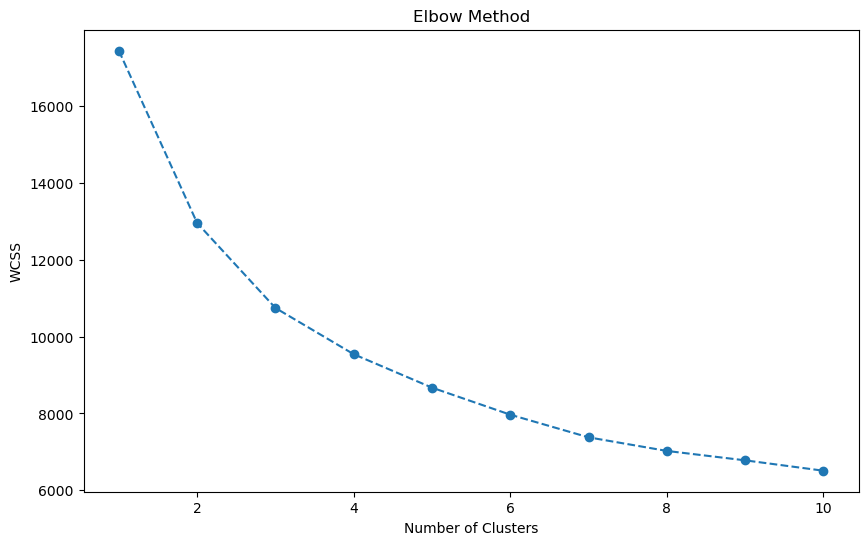

In [96]:
# Determine the optimal number of clusters using the Elbow Method
wcss = []  # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [97]:
# Perfom clusters
optimal_clusters = 5
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

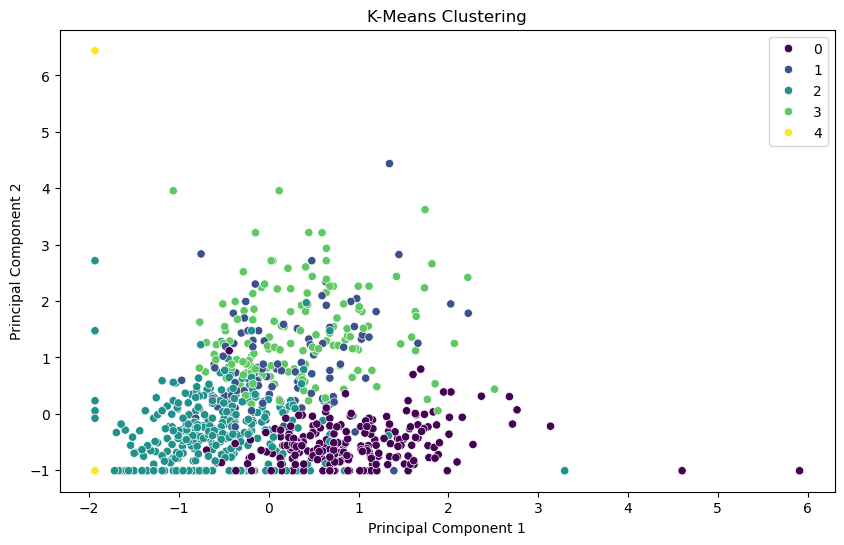

Cluster Profiles:
         d_zone_shift_starts  giveaways     goals  high_danger_goals  \
Cluster                                                                
0                   0.313284   0.109335  1.461129           0.018923   
1                   0.314042   0.081294  5.798343           0.165943   
2                   0.172642   0.050005  1.887182           0.044182   
3                   0.219609   0.088544  7.330988           0.219187   
4                   0.069697   0.022727  0.681818           0.000000   

         high_danger_shots      hits  low_danger_goals  low_danger_shots  \
Cluster                                                                    
0                 0.079006  0.528453          0.006886          0.276731   
1                 0.658019  0.493906          0.011584          0.278055   
2                 0.264257  0.724540          0.004558          0.154582   
3                 0.718377  0.492327          0.016065          0.361021   
4                 0.1

In [98]:
# Add the cluster labels to the original dataframe
players['Cluster'] = clusters

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=clusters, palette='viridis')
plt.title('K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Profile clusters by calculating summary statistics for each cluster
numeric_columns = players.select_dtypes(include=['float64', 'int64']).columns
cluster_profiles = players.groupby('Cluster')[numeric_columns].mean()
print("Cluster Profiles:")
print(cluster_profiles)

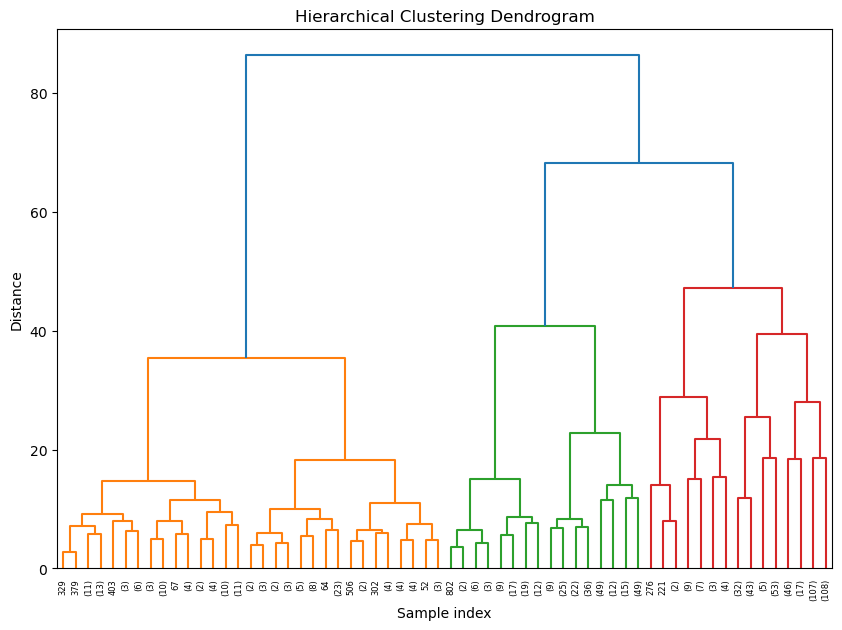

In [99]:
# Perform Hierarchical Clustering
Z = linkage(X_scaled, method='ward')

# Visualize the Dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

# Assign cluster labels
max_d = 50  # Set the maximum distance threshold
clusters = fcluster(Z, max_d, criterion='distance')

# Add the cluster labels to the original dataframe
players['Cluster'] = clusters

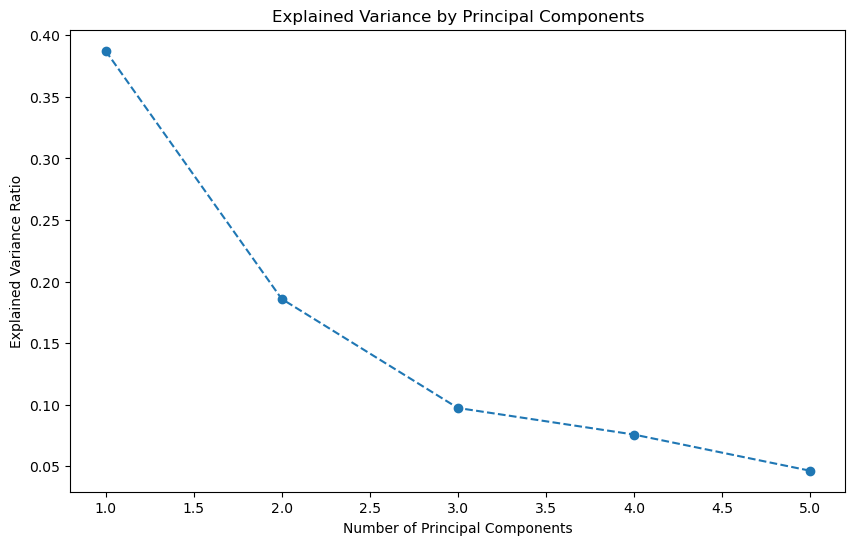

In [100]:
#Perform PCA
pca = PCA(n_components=5)
principal_components = pca.fit_transform(X_scaled)

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.show()


In [101]:
# Get weights of the features
loadings = pca.components_[0]

# Create a df for the loadings
loadings_df = pd.DataFrame({
    'feature': features,
    'loading': loadings
})
# Save the loadings to a CSV file in the 'data' directory
loadings_df.to_csv('/Users/blairjdaniel/lighthouse/lighthouse/NHL/files/master_copies/feature_loadings.csv', index=False)

loadings_df

,feature,loading
0,giveaways,0.191809
1,goals,0.291775
2,high_danger_goals,0.250081
3,high_danger_shots,0.223721
4,hits,-0.095423
5,low_danger_goals,0.239205
6,low_danger_shots,0.280296
7,medium_danger_goals,0.187270
8,medium_danger_shots,0.247243
9,shifts,0.228577


In [102]:
# Load the dict
loadings_dict = dict(zip(loadings_df['feature'], loadings_df['loading']))

def compute_team_score(team_df, loadings):
    score = 0
    for feature, weight in loadings.items():
        if feature in team_df.columns:
            feature_sum = team_df[feature].sum()
            weighted_sum = feature_sum * weight
            score += weighted_sum
    return score

In [103]:
user_data = {
    'name': ['Cale Makar', 'Macklin Celebrini', 'Mathew Barzal', 'Connor McDavid', 'Brandt Clarke'],
    'position': ['D', 'F', 'F', 'F', 'D'],
    'salary': [10000000, 950000, 6000000, 12000000, 950000],
    'd_zone_shift_starts': [50, 30, 40, 60, 45],
    'giveaways': [10, 5, 8, 12, 7],
    'goals': [20, 25, 15, 30, 10],
    'high_danger_goals': [5, 8, 4, 10, 3],
    'high_danger_shots': [30, 40, 25, 50, 20],
    'hits': [15, 10, 12, 20, 8],
    'low_danger_goals': [2, 3, 1, 4, 1],
    'low_danger_shots': [10, 15, 8, 20, 5],
    'medium_danger_goals': [8, 10, 6, 12, 5],
    'medium_danger_shots': [20, 25, 15, 30, 10],
    'missed_shots': [5, 7, 4, 10, 3],
    'o_zone_shift_starts': [60, 40, 50, 70, 55],
    'penalty_minutes': [10, 5, 8, 12, 7],
    'points': [50, 60, 40, 70, 30],
    'rebound_goals': [3, 4, 2, 5, 1],
    'rebounds': [15, 20, 10, 25, 8],
    'shifts': [100, 80, 90, 110, 85],
    'shot_attempts': [200, 250, 150, 300, 120],
    'shots_on_goal': [100, 120, 80, 150, 60],
    'takeaways': [20, 15, 18, 25, 12],
    'faceoffs_lost': [30, 20, 25, 35, 15],
    'faceoffs_won': [40, 30, 35, 50, 25],
    'games_played': [50, 60, 40, 70, 30],
    'icetime': [1200, 1000, 1100, 1300, 1050],
    'on_ice_corsi_percentage': [55, 60, 50, 65, 45],
    'on_ice_fenwick_percentage': [53, 58, 48, 63, 43],
    'penalties_drawn': [5, 3, 4, 6, 2],
    'shots_blocked_by_player': [10, 8, 7, 12, 5],
    'assists': [30, 35, 25, 40, 20]
    
}

user_team = pd.DataFrame(user_data)
user_team


,name,position,salary,d_zone_shift_starts,giveaways,goals,high_danger_goals,high_danger_shots,hits,low_danger_goals,...,takeaways,faceoffs_lost,faceoffs_won,games_played,icetime,on_ice_corsi_percentage,on_ice_fenwick_percentage,penalties_drawn,shots_blocked_by_player,assists
0,Cale Makar,D,10000000,50,10,20,5,30,15,2,...,20,30,40,50,1200,55,53,5,10,30
1,Macklin Celebrini,F,950000,30,5,25,8,40,10,3,...,15,20,30,60,1000,60,58,3,8,35
2,Mathew Barzal,F,6000000,40,8,15,4,25,12,1,...,18,25,35,40,1100,50,48,4,7,25
3,Connor McDavid,F,12000000,60,12,30,10,50,20,4,...,25,35,50,70,1300,65,63,6,12,40
4,Brandt Clarke,D,950000,45,7,10,3,20,8,1,...,12,15,25,30,1050,45,43,2,5,20


In [104]:
ai_data = {
    'name': ['Cale Makar', 'J-P Dumont', 'Connor McMichael', 'Connor McDavid', 'Evan Bouchard'],
    'position': ['D', 'F', 'F', 'F', 'D'],
    'salary': [10000000, 950000, 950000, 12000000, 8000000],
    'd_zone_shift_starts': [45, 25, 35, 55, 40],
    'giveaways': [8, 4, 6, 10, 5],
    'goals': [18, 20, 12, 28, 9],
    'high_danger_goals': [4, 6, 3, 9, 2],
    'high_danger_shots': [25, 35, 20, 45, 18],
    'hits': [12, 8, 10, 18, 6],
    'low_danger_goals': [1, 2, 1, 3, 1],
    'low_danger_shots': [8, 12, 6, 18, 4],
    'medium_danger_goals': [6, 8, 4, 10, 4],
    'medium_danger_shots': [15, 20, 10, 25, 8],
    'missed_shots': [4, 5, 3, 8, 2],
    'o_zone_shift_starts': [55, 35, 45, 65, 50],
    'penalty_minutes': [8, 4, 6, 10, 5],
    'points': [45, 50, 35, 65, 25],
    'rebound_goals': [2, 3, 1, 4, 1],
    'rebounds': [12, 15, 8, 20, 6],
    'shifts': [90, 70, 80, 100, 75],
    'shot_attempts': [180, 220, 130, 270, 100],
    'shots_on_goal': [90, 100, 70, 140, 50],
    'takeaways': [18, 12, 15, 22, 10],
    'faceoffs_lost': [25, 15, 20, 30, 12],
    'faceoffs_won': [35, 25, 30, 45, 20],
    'games_played': [45, 55, 35, 65, 25],
    'icetime': [1100, 900, 1000, 1200, 950],
    'on_ice_corsi_percentage': [52, 57, 47, 62, 42],
    'on_ice_fenwick_percentage': [50, 55, 45, 60, 40],
    'penalties_drawn': [4, 2, 3, 5, 1],
    'shots_blocked_by_player': [8, 6, 5, 10, 4],
    'assists': [28, 30, 20, 38, 18]
}
ai_team = pd.DataFrame(ai_data)
ai_team

,name,position,salary,d_zone_shift_starts,giveaways,goals,high_danger_goals,high_danger_shots,hits,low_danger_goals,...,takeaways,faceoffs_lost,faceoffs_won,games_played,icetime,on_ice_corsi_percentage,on_ice_fenwick_percentage,penalties_drawn,shots_blocked_by_player,assists
0,Cale Makar,D,10000000,45,8,18,4,25,12,1,...,18,25,35,45,1100,52,50,4,8,28
1,J-P Dumont,F,950000,25,4,20,6,35,8,2,...,12,15,25,55,900,57,55,2,6,30
2,Connor McMichael,F,950000,35,6,12,3,20,10,1,...,15,20,30,35,1000,47,45,3,5,20
3,Connor McDavid,F,12000000,55,10,28,9,45,18,3,...,22,30,45,65,1200,62,60,5,10,38
4,Evan Bouchard,D,8000000,40,5,9,2,18,6,1,...,10,12,20,25,950,42,40,1,4,18


In [105]:
# Compute the scores
user_score = compute_team_score(user_team, loadings_dict)
ai_score = compute_team_score(ai_team, loadings_dict)

# print("User team score:", user_score)
# print("AI team score:", ai_score)

# Normalize the scores
scaling_factor = 1000  # Adjust this factor as needed
normalized_user_score = user_score / scaling_factor
normalized_ai_score = ai_score / scaling_factor

# Round the scores
if normalized_user_score > normalized_ai_score:
    final_user_score = round(normalized_user_score)
    final_ai_score = round(normalized_ai_score)
else:
    final_user_score = round(normalized_user_score)
    final_ai_score = round(normalized_ai_score)

# Ensure the winner's score is rounded up if necessary
if final_user_score == final_ai_score:
    if user_score > ai_score:
        final_user_score += 1
    else:
        final_ai_score += 1

print(f"Team User: {final_user_score}")
print(f"Team AI: {final_ai_score}")

if final_user_score > final_ai_score:
    print("Team User wins!")
else:
    print("Team AI wins!")

Team User: 3
Team AI: 2
Team User wins!
